# EDA and text preprocessing

In [2]:
import re
import warnings
from typing import Optional

from tqdm.notebook import tqdm_notebook
from IPython.display import clear_output

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

tqdm_notebook.pandas()
warnings.filterwarnings('ignore')
np.random.seed(42)

In [84]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import RussianStemmer
from nltk.tokenize.casual import casual_tokenize
from wordcloud import WordCloud
from bs4 import BeautifulSoup

nltk.download('stopwords')
RUSSIAN_STOPWORDS = set(stopwords.words("russian"))
russian_stemmer = RussianStemmer()
clear_output()

In [10]:
CORPS_PATH = "./data/labeled_rusentiment_text.csv"

## Load data

In [70]:
posts_df = pd.read_csv(CORPS_PATH, index_col=0)
posts_df = posts_df.dropna()

In [71]:
if set(posts_df.sentiment.unique()) == {-1, 0, 1}:
    posts_df["sentiment"] = posts_df["sentiment"].replace({-1: "negative", 0: "neutral", 1: "positive"})
    posts_df.to_csv("./data/post_texts.csv", index=False)

In [72]:
posts_df.shape

(356565, 2)

In [73]:
posts_df.head()

,text,sentiment
0,украина это часть руси искусственно отделенная...,negative
1,говорить относительно небольшой коррупции обра...,negative
2,своими поляками сделали русских понятно литовс...,neutral
3,фильмы зрители любят диковинное соседка пятом ...,neutral
4,государство платить посмотрите денежный поток ...,negative


## Exploratory analysis

<AxesSubplot: xlabel='sentiment', ylabel='count'>

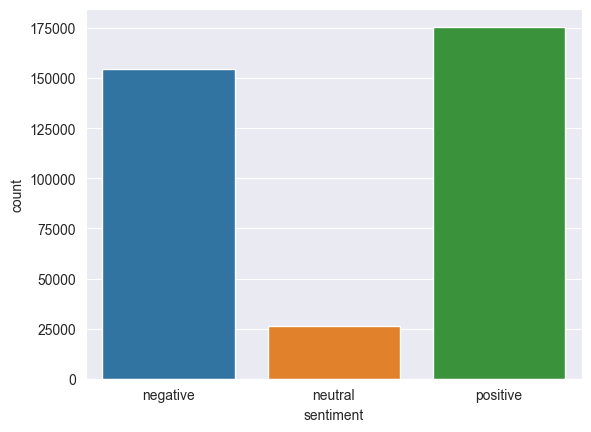

In [74]:
sns.countplot(data=posts_df, x="sentiment")

<AxesSubplot: xlabel='word number', ylabel='Density'>

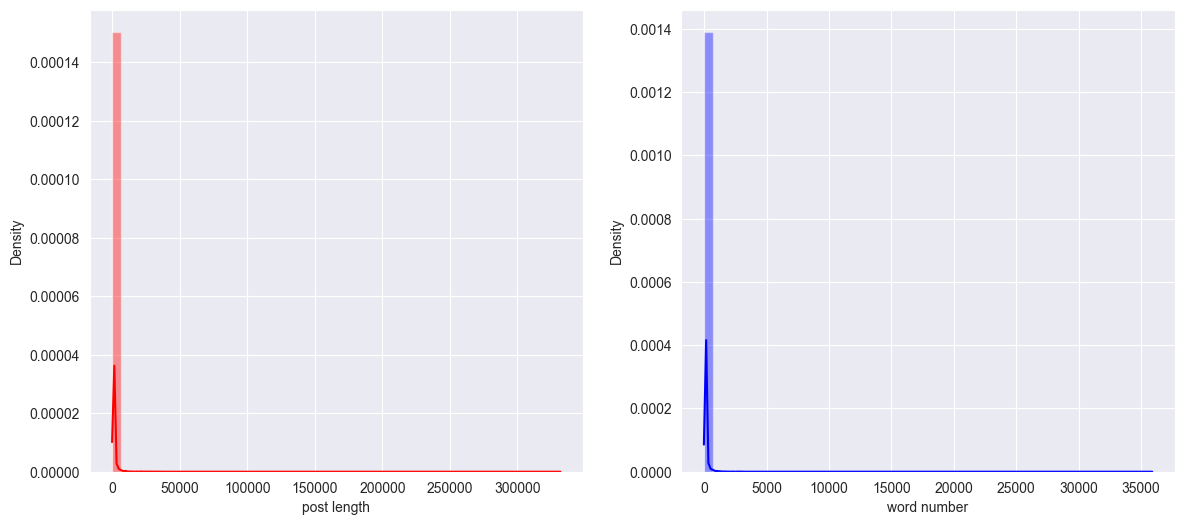

In [75]:
sentence_len = posts_df["text"].apply(lambda row: len(str(row))).rename("post length")
word_count = posts_df["text"].apply(lambda row: len(str(row).split(" "))).rename("word number")
fig = plt.figure(figsize=(14, 6))
fig.add_subplot(1, 2, 1)
sns.distplot(sentence_len, color='red')
fig.add_subplot(1, 2, 2)
sns.distplot(word_count, color='blue')

In [76]:
sentence_len.describe()

count    356565.000000
mean        216.743068
std        1287.355330
min           2.000000
25%          34.000000
50%          54.000000
75%          97.000000
max      331681.000000
Name: post length, dtype: float64

In [77]:
word_count.describe()

count    356565.000000
mean         26.053942
std         141.137524
min           1.000000
25%           5.000000
50%           7.000000
75%          13.000000
max       35863.000000
Name: word number, dtype: float64

## Word Cloud

In [78]:
def plot_most_frequency_word_cloud(document: str, stop_words: set = RUSSIAN_STOPWORDS) -> None:
    cloud = WordCloud(width=800, height=600, stopwords=stop_words).generate(document)
    plt.figure(figsize=(16, 10))
    plt.imshow(cloud)
    plt.axis('off')

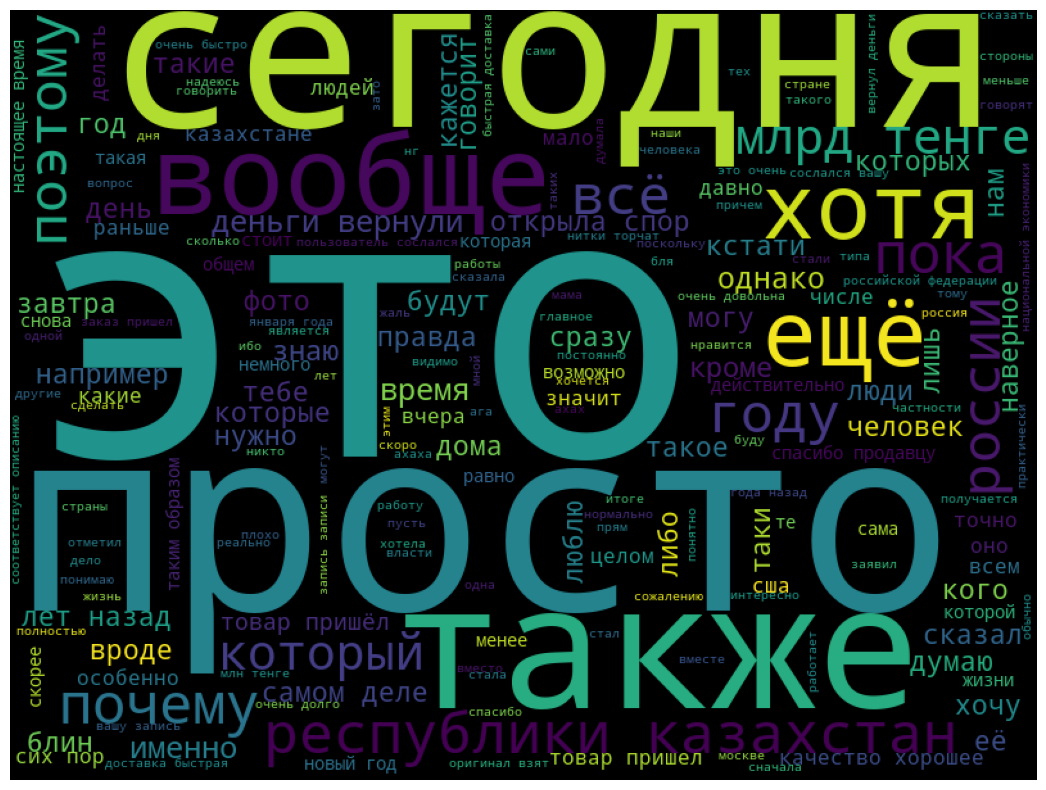

In [79]:
plot_most_frequency_word_cloud(" ".join(posts_df["text"].apply(str).tolist()))

## Cleaning text

In [80]:
def clean_data(string: str) -> str:
    text = BeautifulSoup(string, "lxml").get_text()

    letters_only = re.sub("[^а-яА-ЯёЁ]", " ", text)

    lowercase_text = letters_only.lower()

    string_without_stopwords = " ".join(
        [
            word for word in lowercase_text.split()
            if word not in RUSSIAN_STOPWORDS
        ])
    return string_without_stopwords

In [81]:
clean_text_df = posts_df.copy()

In [86]:
clean_text_df["text"] = clean_text_df["text"].progress_apply(clean_data)

  0%|          | 0/356565 [00:00<?, ?it/s]

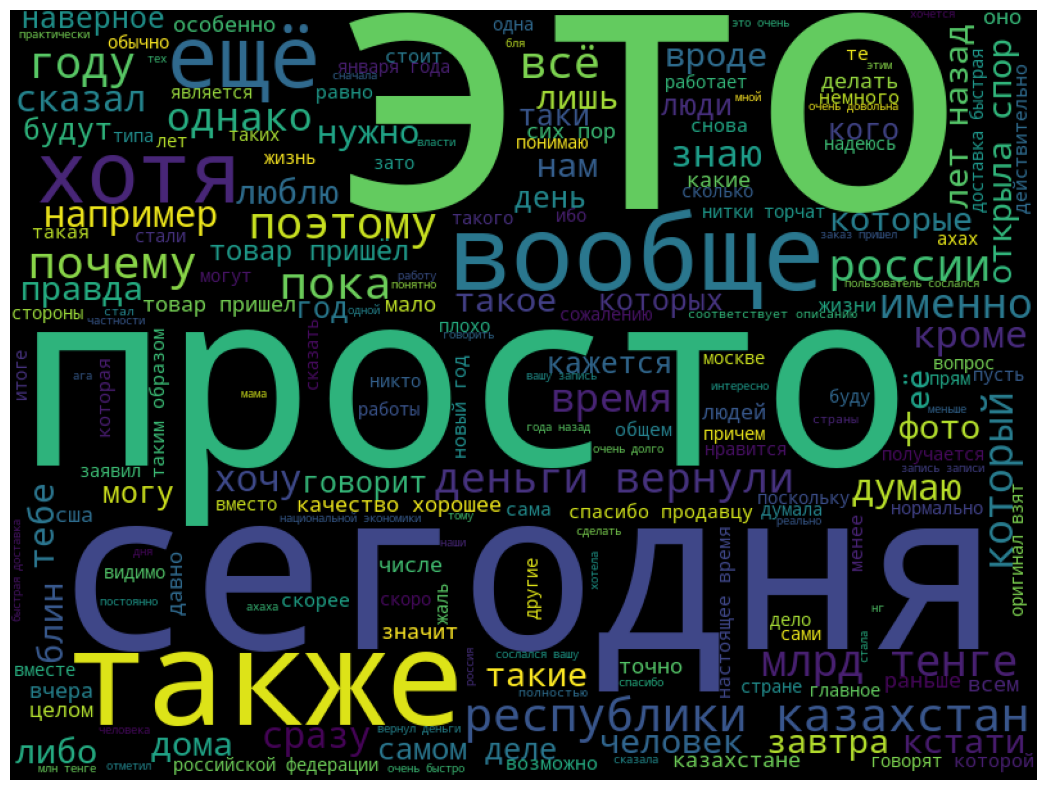

In [87]:
plot_most_frequency_word_cloud(" ".join(clean_text_df["text"].tolist()))

In [88]:
clean_text_df.to_csv("./data/clean_post_texts.csv", index=False)

## Stemming

In [89]:
def stemming(sentence: str, stemmer=russian_stemmer) -> Optional[str]:
    try:
        stemmer_words = [stemmer.stem(token) for token in casual_tokenize(sentence)]
        return " ".join(stemmer_words)
    except Exception:
        return None

In [96]:
# example
print(f"Input sentence:\n{posts_df.iloc[0]['text']}")
print(f"After stemming sentence:\n{stemming(posts_df.iloc[0]['text'])}")

Input sentence:
украина это часть руси искусственно отделенная которой русских людей течении лет переформатируют мозги против россии вали отсюда нахуй израильский чурка хотят хохлы частью рашкостана кавказороссиянии нужна хохлам духовная общность черножопыми дикарями москвабадской красной площади новый год одни чурки одной русской рожи хохлы хотят такого обезьянника киеве лет братские украинцы будут срать русских говнорашку поляки русские будут смешиваться чурками растворяться чурках
After stemming sentence:
украин эт част рус искусствен отделен котор русск люд течен лет переформатир мозг прот росс вал отсюд нах израильск чурк хот хохл част рашкоста кавказороссиян нужн хохл духовн общност черножоп дикар москвабадск красн площад нов год одн чурк одн русск рож хохл хот так обезьянник киев лет братск украинц будут срат русск говнорашк поляк русск будут смешива чурк растворя чурк


In [94]:
stemming_text_df = clean_text_df.copy()
stemming_text_df["text"] = stemming_text_df["text"].progress_apply(lambda string: stemming(string))

  0%|          | 0/356565 [00:00<?, ?it/s]

In [95]:
stemming_text_df.to_csv("./data/stemming_post_texts.csv", index=False)